# Must Run

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopy.distance
import seaborn as sns
import glob
import os
import scipy as sci
import scipy.signal as sig
import scipy.spatial as spa
import scipy.stats as stat
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

ex = './Historical Data/%s.csv'
path = ex % 'LCM'
!wc -1 $psth

wc: illegal option -- 1
usage: wc [-clmw] [file ...]


# Bird

In [2]:
import zipfile
with zipfile.ZipFile('./PollenandBird/Bird migration in the Mediterranean storm petrel.zip', 'r') as zip_ref:
    zip_ref.extractall('./PollenandBird')

In [3]:
#upload pollen dataset as csv
pmm = pd.read_csv('./PollenandBird/Partial migration in the Mediterranean storm petrel (BirdLife Malta).csv')

#make columns manageable
pmm['timestamp'] =  pd.to_datetime(pmm['timestamp'])
pmm['Date'] = pmm['timestamp'].dt.date
pmm['Time'] = pmm['timestamp'].dt.time
pmm['Coordinates']  = list(zip(pmm['location-lat'], pmm['location-long']))

#drop unwanted columns and NaNs
smallpmm = pmm.drop(labels=['event-id', 'visible', 'timestamp',
       'bas:confidence', 'end-timestamp', 'geolocator-fix-type',
       'gls:light-level', 'manually-marked-outlier', 'start-timestamp',
       'sensor-type', 'individual-taxon-canonical-name', 'individual-local-identifier', 'study-name', 'Coordinates'], axis = 1)
smallpmmnumbers = smallpmm.dropna()
smallpmmnumbers['Coordinates']  = list(zip(smallpmmnumbers['location-lat'], smallpmmnumbers['location-long']))
indexedpmm = smallpmmnumbers.set_index(['tag-local-identifier'])

/Users/athenaye/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3-97fa22a40e5d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smallpmmnumbers['Coordinates']  = list(zip(smallpmmnumbers['location-lat'], smallpmmnumbers['location-long']))


In [4]:
#Make a dataset for animal 659
sixfivenine = pd.DataFrame()
for x in range(len(indexedpmm.index)):
    if indexedpmm.index[x] == 'Z659':
        sixfivenine = pd.concat([sixfivenine, indexedpmm.iloc[x]], axis = 1)
sixfivenine = sixfivenine.T
sixfivenine['Date'] = pd.to_datetime(sixfivenine['Date'])
sixfivenine = sixfivenine.set_index('Date')
sixfivenine['location-longint'] = sixfivenine['location-long'].astype(str).astype(float)
sixfivenine['location-latint'] = sixfivenine['location-lat'].astype(str).astype(float)

#group 659
groupedsixfivenine = sixfivenine.groupby('Date')['location-longint','location-latint'].mean()
groupedsixfivenine['MeanCoordinates']  = list(zip(groupedsixfivenine['location-latint'], groupedsixfivenine['location-longint']))

<ipython-input-4-c857c8e0be9b>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupedsixfivenine = sixfivenine.groupby('Date')['location-longint','location-latint'].mean()


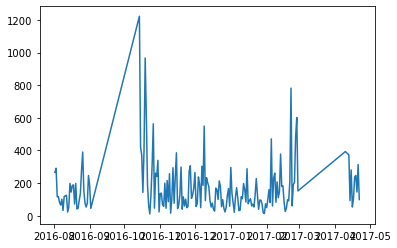

In [5]:
#Make a plot for distance per day
distperdayarr = np.empty(len(groupedsixfivenine))
for x in range(len(groupedsixfivenine)):
    coord1 = groupedsixfivenine['MeanCoordinates'].iloc[x]
    coord2 = groupedsixfivenine['MeanCoordinates'].iloc[x-1]
    distperdayarr[x] = geopy.distance.distance(coord1, coord2).km
distperday = pd.DataFrame(distperdayarr)
distperday = distperday.set_index(groupedsixfivenine.index)
plt.plot(distperday)

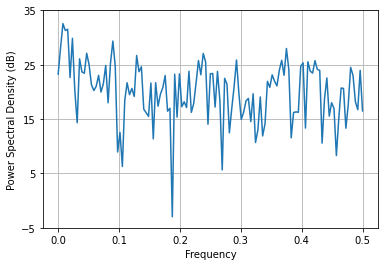

In [6]:
#PSD of distance per day with an NFFT of 2^8, with plt.psd() detrending the data
a, b = plt.psd(distperday, Fs = 1, scale_by_freq = False, NFFT = 2**8, detrend = 'linear')
distperdaydataarg = a
distperdayindexarg = b
zdistperdayinmeeting = stat.zscore(distperdaydataarg)

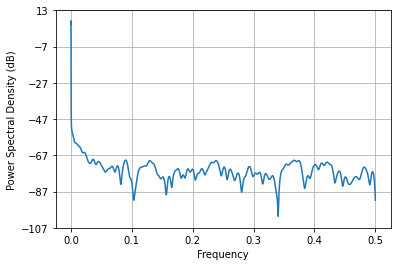

In [7]:
#PSD of distance per day with an NFFT of 2^14, with plt.psd() detrending the data
a, b = plt.psd(distperday, Fs = 1, scale_by_freq = False, NFFT = 2**14, detrend = 'linear')

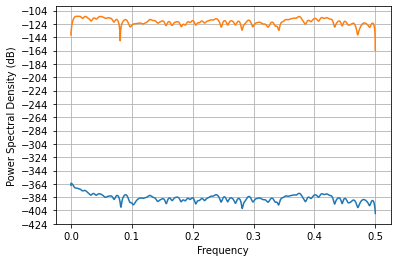

In [8]:
#Detrending distance per day with sig.detrend()
dtdistperday = sig.detrend(distperday)
dtdistperday = pd.DataFrame(dtdistperday)
dtadistperday,dtbdistperday = plt.psd(dtdistperday, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue

#Z-scored data of dist per day with sig.detrend()
zdistperday = stat.zscore(dtdistperday)
zdistperday = pd.DataFrame(zdistperday)
zadistperday,zbdistperday = plt.psd(zdistperday, Fs = 1, scale_by_freq = False, NFFT = 2**14 )

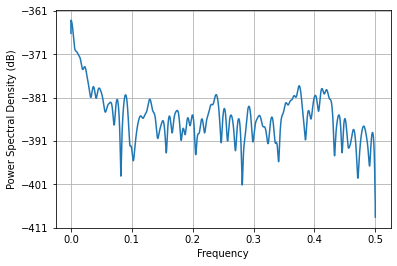

In [9]:
#PSD of distance per day with an NFFT of 2^14, with sig.detrend() detrending the data
a, b = plt.psd(dtdistperday, Fs = 1, scale_by_freq = False, NFFT = 2**14)

# Pollen

In [10]:
pollen = pd.read_csv('./PollenandBird/pollen.csv', index_col = 'Date')
pollen = pollen.sort_index()
simple = pollen.set_index(np.array(range(0,7784)))

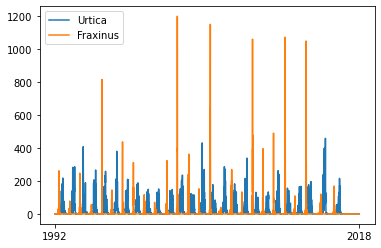

In [11]:
#plotting two very different pollen genuses
plt.plot(simple['Urtica'])
plt.plot(simple['Fraxinus'])
plt.xticks((0,7784), (1992,2018))
plt.legend(('Urtica','Fraxinus'), loc="upper left")

([<matplotlib.axis.XTick at 0x7fbfab6a4700>,
 [Text(0, 0, '1992'), Text(7784, 0, '2018')])

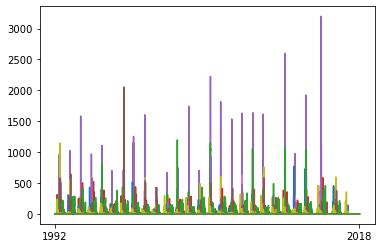

In [12]:
#Pollen Graph
plt.plot(simple)
plt.xticks((0,7784), (1992,2018))

In [13]:
#Pollen Mean
pollenmean=pollen.mean(axis=(1))
pollenmean

Date
1992-01-01    0.000000
1992-01-02    0.000000
1992-01-03    0.000000
1992-01-04    0.000000
1992-01-05    0.000000
                ...   
2018-12-27    0.000000
2018-12-28    0.121212
2018-12-29    0.000000
2018-12-30    0.000000
2018-12-31    0.000000
Length: 7784, dtype: float64

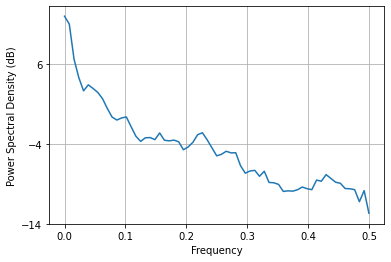

In [14]:
#PSD of pollen mean with an NFFT of 2^7
a, b = plt.psd(pollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**7)

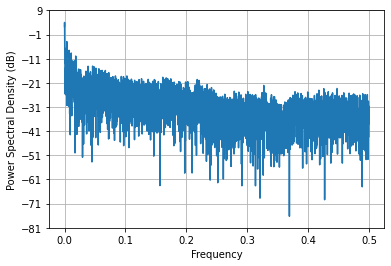

In [15]:
#PSD of pollen mean with an NFFT of 2^14
a, b = plt.psd(pollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14)
pollenmeandata = a
pollenmeanindex = b

### Detrended and Z-Score  Pollen

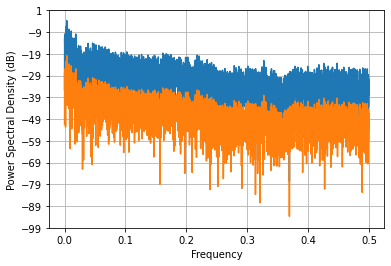

In [16]:
dtpollenmean = sig.detrend(pollenmean)
dtpollenmean = pd.DataFrame(dtpollenmean)
dtapollenmean,dtbpollenmean = plt.psd(dtpollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue
zpollenmean = stat.zscore(dtpollenmean)
zpollenmean = pd.DataFrame(zpollenmean)
zapollenmean,zbpollenmean = plt.psd(zpollenmean, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in orange

## All Pollen

In [17]:
urtica = simple['Urtica']
frax = simple['Fraxinus']

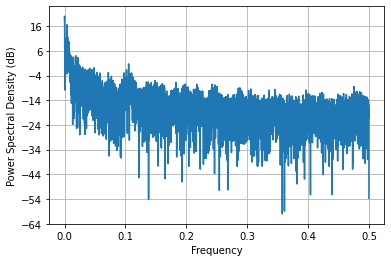

In [18]:
#PSD of Urtica
a, b = plt.psd(urtica, Fs = 1, scale_by_freq = False, NFFT = 2**14)
urticadata = a
urticaindex = b

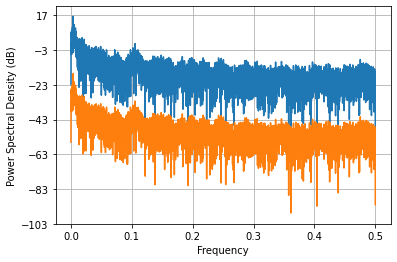

In [19]:
#Detrended Urtica
dturtica = sig.detrend(urtica)
dturtica = pd.DataFrame(dturtica)
dtaurtica,dtburtica = plt.psd(dturtica, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue

#Z-scored Urtica
zurtica = stat.zscore(dturtica)
zurtica = pd.DataFrame(zurtica)
zaurtica,zburtica = plt.psd(zurtica, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in orange

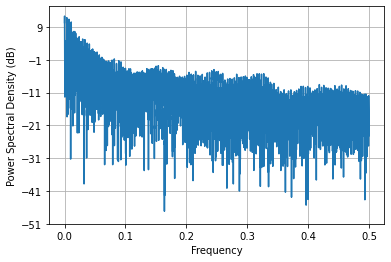

In [20]:
#PSD of frax
a, b = plt.psd(frax, Fs = 1, scale_by_freq = False, NFFT = 2**14)
fraxdata = a
fraxindex = b

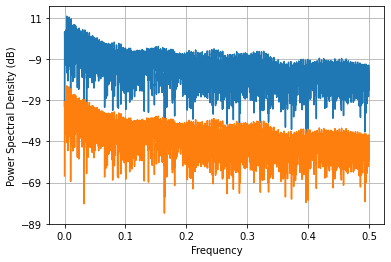

In [21]:
#Detrended Urtica
dtfrax = sig.detrend(frax)
dtfrax = pd.DataFrame(dtfrax)
dtafrax,dtbfrax = plt.psd(dtfrax, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in blue

#Z-scored Urtica
zfrax = stat.zscore(dtfrax)
zfrax = pd.DataFrame(zfrax)
zafrax,zbfrax = plt.psd(zfrax, Fs = 1, scale_by_freq = False, NFFT = 2**14 ) #in orange

# AWND

In [22]:
years = []
stationlist = ['AQW00061705', 'FMW00040308','GQW00041415', 'RQW00011641', 'USC00244558']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("./NOAAData/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'AWND'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
awndoverall = ultimate.sort_values(by='date')

KeyboardInterrupt: 

In [ ]:
for x in range(len(awndoverall.columns)):
    nonan = awndoverall[awndoverall.columns[x]]
    nonan = nonan.interpolate('linear')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
aawndmean = acumulative.mean(axis=(0))
bawndmean = bcumulative.mean(axis=(0))

### Detrended

In [ ]:
dtawnd = pd.DataFrame()
zawnd = pd.DataFrame()
for x in range(len(awndoverall.columns)):
    dtnonan = awndoverall[awndoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zawnd = pd.concat([zawnd, zscore], axis = 1)
    dtawnd = pd.concat([dtawnd, detrend], axis = 1)

In [ ]:
for x in range(len(dtawnd.columns)):
    dtnonan = awndoverall[awndoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtaawnd = acumulative.mean(axis=(0))
dtbawnd = bcumulative.mean(axis=(0))

### Z-Scored

In [ ]:
for x in range(len(zawnd.columns)):
    znonan = awndoverall[awndoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zaawnd = acumulative.mean(axis=(0))
zbawnd = bcumulative.mean(axis=(0))
print(a.size)

# TAVG

In [ ]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TAVG'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        f['station '+str(stationlist[s])] = stationtavg
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
avgoverall = ultimate.sort_values(by='date')

In [ ]:
for x in range(len(avgoverall.columns)):
    nonan = avgoverall[avgoverall.columns[x]]
    nonan = nonan.interpolate('linear')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
amean = acumulative.mean(axis=(0))
bmean = bcumulative.mean(axis=(0))

### Detrended

In [ ]:
dt = pd.DataFrame()
zmean = pd.DataFrame()
for x in range(len(avgoverall.columns)):
    dtnonan = avgoverall[avgoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zmean = pd.concat([zmean, zscore], axis = 1)
    dt = pd.concat([dt, detrend], axis = 1)

In [ ]:
for x in range(len(dt.columns)):
    dtnonan = avgoverall[avgoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtamean = acumulative.mean(axis=(0))
dtbmean = bcumulative.mean(axis=(0))

### Z-Scored

In [ ]:
for x in range(len(avgoverall.columns)):
    znonan = avgoverall[avgoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zamean = acumulative.mean(axis=(0))
zbmean = bcumulative.mean(axis=(0))

# TMAX

In [ ]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TMAX'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
maxoverall = ultimate.sort_values(by='date')
sns.lineplot(data = maxoverall, legend = False)

In [ ]:
for x in range(len(maxoverall.columns)):
    nonan = maxoverall[maxoverall.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    
    if x == 0:
        tmaxacumulative = a
        tmaxbcumulative = b
    else:
        tmaxacumulative = np.vstack([tmaxacumulative, a])
        tmaxbcumulative = np.vstack([tmaxbcumulative, b])
tmaxamean = np.nanmean(tmaxacumulative, axis=(0))
tmaxbmean = np.nanmean(tmaxbcumulative, axis=(0))

### Detrended

In [ ]:
dttmax = pd.DataFrame()
ztmax = pd.DataFrame()
for x in range(len(maxoverall.columns)):
    dtnonan = maxoverall[maxoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    ztmax = pd.concat([ztmax, zscore], axis = 1)
    dttmax = pd.concat([dttmax, detrend], axis = 1)

In [ ]:
for x in range(len(dttmax.columns)):
    dtnonan = maxoverall[maxoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtatmax = acumulative.mean(axis=(0))
dtbtmax = bcumulative.mean(axis=(0))

### Z-Scored

In [ ]:
for x in range(len(ztmax.columns)):
    znonan = maxoverall[maxoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zatmax = acumulative.mean(axis=(0))
zbtmax = bcumulative.mean(axis=(0))

# TMIN

In [ ]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'TMIN'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
minoverall = ultimate.sort_values(by='date')
sns.lineplot(data = minoverall, legend = False)

In [ ]:
for x in range(len(minoverall.columns)):
    nonan = minoverall[minoverall.columns[x]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    
    if x == 0:
        tminacumulative = a
        tminbcumulative = b
    else:
        tminacumulative = np.vstack([tminacumulative, a])
        tminbcumulative = np.vstack([tminbcumulative, b])
tminamean = np.nanmean(tminacumulative, axis=(0))
tminbmean = np.nanmean(tminbcumulative, axis=(0))

### Detrended

In [ ]:
dttmin = pd.DataFrame()
ztmin = pd.DataFrame()
for x in range(len(minoverall.columns)):
    dtnonan = minoverall[minoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear', limit_direction = 'both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    ztmin = pd.concat([ztmin, zscore], axis = 1)
    dttmin = pd.concat([dttmin, detrend], axis = 1)

In [ ]:
for x in range(len(dt.columns)):
    dtnonan = minoverall[minoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear', limit_direction = 'both')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtamin = acumulative.mean(axis=(0))
dtbmin = bcumulative.mean(axis=(0))

### Z-Scored

In [ ]:
for x in range(len(minoverall.columns)):
    znonan = minoverall[minoverall.columns[x]]
    znonan = znonan.interpolate('linear', limit_direction = 'both')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zamin = acumulative.mean(axis=(0))
zbmin = bcumulative.mean(axis=(0))

# PRCP

In [ ]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AG000060390']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'PRCP'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
prcpoverall = ultimate.sort_values(by='date')
sns.lineplot(data = prcpoverall, legend = False)

In [ ]:
for x in range(len(prcpoverall.columns)):
    nonan = prcpoverall[prcpoverall.columns[x]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    
    if x == 0:
        prcpacumulative = a
        prcpbcumulative = b
    else:
        prcpacumulative = np.vstack([prcpacumulative, a])
        prcpbcumulative = np.vstack([prcpbcumulative, b])
prcpamean = np.nanmean(prcpacumulative, axis=(0))
prcpbmean = np.nanmean(prcpbcumulative, axis=(0))

### Detrended

In [ ]:
dtprcp = pd.DataFrame()
zprcp = pd.DataFrame()
for x in range(len(prcpoverall.columns)):
    dtnonan = prcpoverall[prcpoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    zscore = stat.zscore(detrend)
    zscore = pd.DataFrame(zscore)
    zprcp = pd.concat([zprcp, zscore], axis = 1)
    dtprcp = pd.concat([dtprcp, detrend], axis = 1)

In [ ]:
for x in range(len(dt.columns)):
    dtnonan = prcpoverall[prcpoverall.columns[x]]
    dtnonan = dtnonan.interpolate('linear')
    detrend = sig.detrend(dtnonan)
    detrend = pd.DataFrame(detrend)
    a,b = plt.psd(detrend, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
dtaprcp = acumulative.mean(axis=(0))
dtbprcp = bcumulative.mean(axis=(0))

### Z-Scored

In [ ]:
for x in range(len(zprcp.columns)):
    znonan = prcpoverall[prcpoverall.columns[x]]
    znonan = znonan.interpolate('linear')
    zscore = stat.zscore(znonan)
    zscore = pd.DataFrame(zscore)
    a,b = plt.psd(zscore, Fs = 1, scale_by_freq = False, NFFT = 2**14 )
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
zaprcp = acumulative.mean(axis=(0))
zbprcp = bcumulative.mean(axis=(0))

# Frequency vs. Power Heatmap

In [ ]:
param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']
param9 = ['Bird Dist']

hm1 = pd.DataFrame(data = amean, columns = param1, index = bmean)
hm2 = pd.DataFrame(data = tmaxamean, columns = param2, index = tmaxbmean)
hm3 = pd.DataFrame(data = tminamean, columns = param3, index = tminbmean)
hm4 = pd.DataFrame(data = prcpamean, columns = param4, index = prcpbmean)
hm5 = pd.DataFrame(data = aawndmean, columns = param5, index = bawndmean)
hm6 = pd.DataFrame(data = pollenmeandata, columns = param6, index = pollenmeanindex)
hm7 = pd.DataFrame(data = urticadata, columns = param7, index = urticaindex)
hm8 = pd.DataFrame(data = fraxdata, columns = param8, index = fraxindex)
hm9 = pd.DataFrame(data = distperdaydata, columns = param9, index = distperdayindex)
hm = pd.concat([hm2, hm1, hm3, hm4, hm5, hm6, hm7, hm8, hm9], axis=1)
loghm = np.log(hm)
fig = sns.heatmap(loghm.T)

# Period vs. Power Heatmap

In [ ]:
param = ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'AWND', 'Pollen', 'Urtica', 'Fraxinus', 'Bird Dist']
interpolated = pd.DataFrame()
for x in range(len(param)):
    base = sci.interpolate.interp1d(1/hm.index[1:],hm.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    interpolated = pd.concat([interpolated, series], axis = 1)
    interpolated.rename_axis('frequency')
    interpolated.rename_axis('measurement', axis='columns')
interpolated.columns = param

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(interpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

# Detrended

In [ ]:
param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']
param9 = ['Bird Dist']

dthm1 = pd.DataFrame(data = dtamean, columns = param1, index = dtbmean)
dthm2 = pd.DataFrame(data = dtatmax, columns = param2, index = dtbtmax)
dthm3 = pd.DataFrame(data = dtamin, columns = param3, index = dtbmin)
dthm4 = pd.DataFrame(data = dtaprcp, columns = param4, index = dtbprcp)
dthm5 = pd.DataFrame(data = dtaawnd, columns = param5, index = dtbawnd)
dthm6 = pd.DataFrame(data = dtapollenmean, columns = param6, index = dtbpollenmean)
dthm7 = pd.DataFrame(data = dtaurtica, columns = param7, index = dtburtica)
dthm8 = pd.DataFrame(data = dtafrax, columns = param8, index = dtbfrax)
dthm9 = pd.DataFrame(data = dtadistperday, columns = param9, index = dtbdistperday)
dthm = pd.concat([dthm2, dthm1, dthm3, dthm4, dthm5, dthm6, dthm7, dthm8, dthm9], axis=1)
dtloghm = np.log(dthm)

In [ ]:
param = ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'AWND', 'Pollen', 'Urtica', 'Fraxinus']
dtinterpolated = pd.DataFrame()
for x in range(len(param)):
    base = sci.interpolate.interp1d(1/dthm.index[1:],dthm.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    dtinterpolated = pd.concat([dtinterpolated, series], axis = 1)
    dtinterpolated.rename_axis('frequency')
    dtinterpolated.rename_axis('measurement', axis='columns')
dtinterpolated.columns = param

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(dtinterpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap y-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels

# Z-scored

In [ ]:
param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']
param4 = ['PRCP']
param5 = ['AWND']
param6 = ['Pollen']
param7 = ['Urtica']
param8 = ['Fraxinus']

zhm1 = pd.DataFrame(data = zamean, columns = param1, index = zbmean)
zhm2 = pd.DataFrame(data = zatmax, columns = param2, index = zbtmax)
zhm3 = pd.DataFrame(data = zamin, columns = param3, index = zbmin)
zhm4 = pd.DataFrame(data = zaprcp, columns = param4, index = zbprcp)
zhm5 = pd.DataFrame(data = zaawnd, columns = param5, index = zbawnd)
zhm6 = pd.DataFrame(data = zapollenmean, columns = param6, index = zbpollenmean)
zhm7 = pd.DataFrame(data = zaurtica, columns = param7, index = zburtica)
zhm8 = pd.DataFrame(data = zafrax, columns = param8, index = zbfrax)
zhm = pd.concat([zhm2, zhm1, zhm3, zhm4, zhm5, zhm6, zhm7, zhm8], axis=1)
zloghm = np.log(zhm)
zfig = sns.heatmap(zloghm.T)

In [ ]:
param = ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'AWND', 'Pollen', 'Urtica', 'Fraxinus']
zinterpolated = pd.DataFrame()
for x in range(len(param)):
    base = sci.interpolate.interp1d(1/zhm.index[1:],zhm.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    zinterpolated = pd.concat([zinterpolated, series], axis = 1)
    zinterpolated.rename_axis('frequency')
    zinterpolated.rename_axis('measurement', axis='columns')
zinterpolated.columns = param

In [ ]:
yvalues = np.array(range(0,8193)) #y-values
xtickmarkloc = [2, 4, 8, 16, 32, 64, 128, 256, 365, 365*2, 365*4, 365*8, 365*16, 8192] #setting the xtickmark locations (numbers represent the period in days)

x = xvalues #the x-values to interpolate along??
y = yvalues #the y-values to interpolate along??
f = sci.interpolate.interp1d(x, y) #interpolating 
xnew = xtickmarkloc #the desired x-values
ynew = f(xnew) #list of values

In [ ]:
s = sns.heatmap(np.log(zinterpolated.T), cbar_kws={'label': 'Log of Power Spectral Density'}) #creating the heatmap and labeling the color bar
s.set_title('Power Spectral Density') #setting the heatmap title
s.set_xlabel('Period (days)') #setting the heatmap x-axis label
s.set_ylabel('Measurement') #setting the heatmap x-axis label
newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d'] #setting the x-axis labels
plt.xticks(ynew, newlabel) #plotting the x-ticks and the newlabels